In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import pickle
from keras.models import Model
import os
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, log_loss, confusion_matrix
from IPython.display import clear_output
import xgboost as xgb
import gc

In [3]:
#Check Model Quality

def preprocess_image(image):
    """Preprocesses the image for model prediction."""
    return np.expand_dims(image, axis=0)



def predict_with_nn(nn_model, VGG_model, image,dimension):
    # Get features from VGG model
    feature_matrix = VGG_model.predict(image)
    feature_matrix = feature_matrix.reshape((dimension * dimension, -1))

    # Convert to TensorFlow tensor
    feature_tensor = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
    # Predict with the model
    prediction_probs = nn_model(feature_tensor)  # model is your loaded and compiled neural network model
    prediction = tf.nn.softmax(prediction_probs, axis=1)  # As classification dont need softmax we have it here to get probabilities and take the one with the highest argument in the end
    predicted_classes = tf.argmax(prediction, axis=1).numpy()

    # Reshape the predictions back into image format
    prediction_image_NN = predicted_classes.reshape((dimension, dimension))
    return prediction_image_NN,prediction_probs

def predict_with_xgb( xgb_model, VGG_model, image,dimension):
    feature_matrix = VGG_model.predict(image)
    feature_matrix = feature_matrix.reshape(-1, feature_matrix.shape[3])
    prediction = xgb_model.predict(feature_matrix)
    pred_probs = xgb_model.predict_proba(feature_matrix)
    prediction_image = prediction.reshape((dimension, dimension))
    return prediction_image, pred_probs
    
def calculate_metrics(y_true, y_pred, class_values, y_prob=None):
    y_pred_mapped = np.copy(y_pred)
    for class_index, class_value in enumerate(class_values):
        y_pred_mapped[y_pred == class_index] = class_value

    y_true_flatten = y_true.flatten()
    y_pred_flatten = y_pred_mapped.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flatten, y_pred_flatten)
    precision = precision_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    recall = recall_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    f1 = f1_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    iou = jaccard_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    conf_matrix = confusion_matrix(y_true_flatten, y_pred_flatten, labels=class_values)

    # Calculate log loss, ensure y_prob is provided
    logloss = log_loss(y_true_flatten, y_prob) if y_prob is not None else None

    return accuracy, precision, recall, f1, iou, logloss, conf_matrix

def plot_confusion_matrix(conf_matrix, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Grey-Scale:0', 'Grey-Scale:128', 'Grey-Scale:255']
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print the confusion matrix in the plot
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", 
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def compute_and_print_mean_metrics(metrics, label):
    """Computes and prints the mean of the given metrics, including confusion matrix."""
    confusion_matrices = np.array([m[-1] for m in metrics])
    other_metrics = [m[:-1] for m in metrics]  # Exclude the confusion matrix

    # Convert other metrics to a NumPy array and calculate mean
    metrics_array = np.array(other_metrics)
    mean_metrics = np.mean(metrics_array, axis=0)

    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "IoU", "Log Loss"]

    # Print mean for standard metrics and log loss
    for name, mean_metric in zip(metric_names, mean_metrics):
        print(f'Mean {name}: {mean_metric}')

    # Handle Confusion Matrix - Calculate sum/average
    sum_confusion_matrix = np.sum(confusion_matrices, axis=0)
    print("\nSum/Average Confusion Matrix:\n", sum_confusion_matrix)

    # Plot the confusion matrix
    plot_confusion_matrix(sum_confusion_matrix,title = label)


def print_model_metrics(model_NN,model_XGB,VGG_model_t,X_test,y_test, dimension, true_labels = [0, 128, 255]):
    # Initialize lists to store metric scores for each image for both models
    nn_metrics, xgb_metrics = [], []
    number_of_test = 5
    if len(X_test) < 5:
        number_of_test = len(X_test)
    for i in range(number_of_test):
        image = preprocess_image(X_test[i])

        # Predict with Neural Network and XGBoost models
        xgb_prediction, xgb_probs = predict_with_xgb(model_XGB,VGG_model_t, image,dimension)

        nn_prediction, nn_probs = predict_with_nn(model_NN, VGG_model_t, image,dimension)

        # Convert prediction to the same format as ground truth, if necessary
        # Example: nn_prediction_converted = convert_format(nn_prediction)
        # Example: xgb_prediction_converted = convert_format(xgb_prediction)

        # Calculate metrics
        xgb_metrics.append(calculate_metrics(y_test[i].flatten(), xgb_prediction.flatten(),true_labels,xgb_probs))
        nn_metrics.append(calculate_metrics(y_test[i].flatten(), nn_prediction.flatten(),true_labels ,nn_probs))


        # Memory management
        if (i + 1) % 10 == 0:  # Clear memory every 10 iterations
            gc.collect()

    # Print mean metrics for both models
    print("Neural Network Model Metrics:")
    compute_and_print_mean_metrics(nn_metrics,'NN-Classifier Dataset 1')

    print("\nXGBoost Model Metrics:")
    compute_and_print_mean_metrics(xgb_metrics, 'XGBoost-Classifier Dateset 1')

In [4]:
# Define the neural network architecture
class SimpleNN(tf.keras.Model):
    def __init__(self, number_output_classes,dropout_rate=0.05):
        super(SimpleNN, self).__init__()
        self.fc1 = layers.Dense(128, activation='relu')
        self.dropout1 = layers.Dropout(dropout_rate)
        self.fc2 = layers.Dense(number_output_classes)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.dropout1(x, training=training)
        x = self.fc2(x)
        x = self.dropout2(x, training=training)
        return x

def train_simple_nn(epoches, X, Y, model_filename, number_output_classes = 3):
    # Convert the data to TensorFlow tensors
    X_train_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_train_tensor = tf.convert_to_tensor(Y, dtype=tf.int64)

    # Create a TensorFlow Dataset and a DataLoader
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, Y_train_tensor))
    train_loader = train_dataset.shuffle(buffer_size=10000).batch(32)

    # Initialize the model
    model = SimpleNN(number_output_classes,dropout_rate=0.05)

    # Define loss function and optimizer
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Metrics to track loss
    train_loss = tf.keras.metrics.Mean(name='train_loss')

    # Training function
    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

    # Train the model
    best_loss = float('inf')

    for epoch in range(epoches):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        
        for inputs, labels in train_loader:
            train_step(inputs, labels)

        current_loss = train_loss.result()
        if current_loss < best_loss:
            best_loss = current_loss
            model.save_weights(f"./Models/{model_filename}.h5")
            print(f'New best model saved with loss: {best_loss:.4f}')

        print(f'Epoch {epoch + 1}, Loss: {current_loss:.4f}')

In [5]:
def extract_raw_data(dirname, size):
    train_images = []
    for fname in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE) 
        if img is None:
            print(f"Warning: Could not read image {fname} from {dirname}")
            continue 
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        train_stack = np.stack((img,)*3, axis=-1)
        train_images.append(train_stack)   
    return np.array(train_images)

def extract_label_data(dirname, size):
    train_masks = [] 
    for fname in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)    
        if img is None:
            print(f"Warning: Could not read image {fname} from {dirname}")
            continue     
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        train_masks.append(img)
        
    return np.array(train_masks)
def split_data_set_gray_scale(dirname_data, dirname_label, test_size, picture_size, number_of_data = 500):

    if number_of_data < 50:
            X_train, X_test, y_train, y_test = train_test_split(extract_raw_data(dirname_data,picture_size), extract_label_data(dirname_label,picture_size), test_size=test_size, random_state=42)
            return X_train, X_test, y_train, y_test

    else:
        X_train, X_temp, y_train, y_temp = train_test_split(extract_raw_data(dirname_data,picture_size), extract_label_data(dirname_label,picture_size), test_size=test_size, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    #X_train, X_test, y_train, y_test = train_test_split(extract_raw_data(dirname_data,picture_size), extract_label_data(dirname_label,picture_size), test_size=test_size, random_state=42)
    
    y_train = np.expand_dims(y_train, axis=3) 
    y_test = np.expand_dims(y_test, axis=3)
    
    return X_train, X_test, y_train, y_test,X_val,y_val

def features_2_dataframe(features,y_train):

    X=features
    X = X.reshape(-1, X.shape[3]) 
    Y = y_train.reshape(-1)
    dataframe = pd.DataFrame(X)
    dataframe['Label'] = Y
    return dataframe

def get_VGG_model_features(train_data_X,y_train, size):
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(size[0], size[1], 3))
    #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in VGG_model.layers:
        layer.trainable = False
    VGG_model.summary()  #Trainable parameters will be 0
    #After the first 2 convolutional layers the image dimension changes so we take the features vectors after first two layers
    #Load VGG16 model wothout classifier/fully connected layers
    #Talked to the professor and as it seems the input shape makes sure that we can actually run pooling and kernal operations
    VGG_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
    VGG_model.summary()
    features = VGG_model.predict(train_data_X)
    
    return features, features_2_dataframe(features,y_train), VGG_model

def plot_VGG_features(features):
    square = 8
    ix=1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(features[0,:,:,ix-1], cmap='gray')
            ix +=1
    plt.suptitle('Feature Extraction VGG Dataset 1', fontsize=20, y=0.92)  # Add a title to the figure
    plt.show()

<h3>Get features with VGG Net Pretrained weights and plot the features</h3>

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 501, 501, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 501, 501, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 501, 501, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

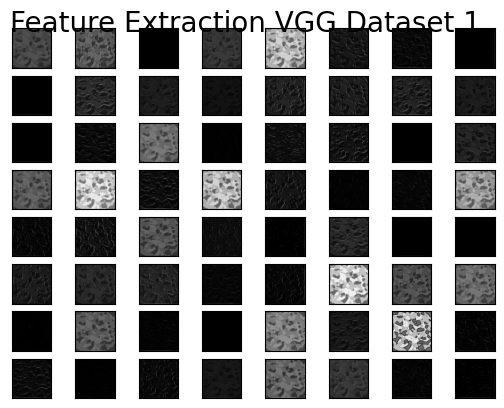

In [6]:
#Get Data
X_train, X_test, y_train, y_test, X_val,y_val = split_data_set_gray_scale('./dataset/data','./dataset/labels', 0.95, [501, 501])
#Train weights
features,dataset,VGG_model = get_VGG_model_features(X_train,y_train,[501,501])
#Plot features
plot_VGG_features(features)

<h3>Prepare Data for Trainig

In [ ]:
#Prepare data for training, for NN the number of samples can still be high
dataset = dataset.sample(frac=0.3, random_state=1)
#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 128: 1, 255: 2}
# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

<h3>Train XGBoost Model</h3>

In [ ]:
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 
#Save model for future use
path = './Models/model_XGBoost_V01.sav'
pickle.dump(model, open(path, 'wb'))


<h3>Train NN Model</h3>

Question is if i can use more data here in the training, than in XGBoost Network?

In [ ]:
#Train NN 
train_simple_nn(300, X_for_training, Y_for_training, 'NN_Model_VGG_Features_V06')

<h3>Load the Models</h3>

In [ ]:
#Load Boost Model
path = './Models/model_XGBoost.sav'
loaded_model_XGB = pickle.load(open(path, 'rb'))
#Load NN Model
number_of_output_classes = 3
model_NN = SimpleNN(number_of_output_classes)  # Replace with your actual model architecture
sample_input = tf.random.normal([1, 64])  # Replace 'input_shape' with the shape of your model input
model_NN(sample_input)
# Load the weights
model_NN.load_weights('./Models/NN_Model_VGG_Features_V06.h5')

<h3>Check Model Quality</h3>

1/1 [==============================] - 0s 84ms/step


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1/1 [==============================] - 0s 47ms/step
Neural Network Model Metrics:
Mean Accuracy: 0.9786733917394752
Mean Precision: 0.9830923678192027
Mean Recall: 0.9745429214064345
Mean F1 Score: 0.9785386070451573
Mean IoU: 0.9580149173498587
Mean Log Loss: 0.37428869818056204

Sum/Average Confusion Matrix:
 [[377417  10443    411]
 [  1249 557019   1301]
 [   602  12759 293804]]


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


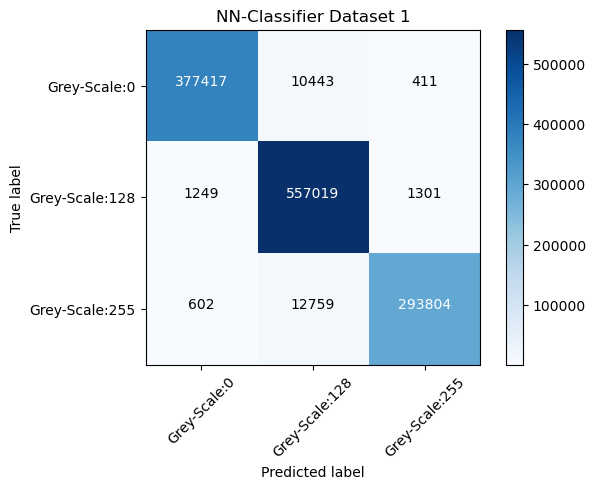


XGBoost Model Metrics:
Mean Accuracy: 0.9875466631607045
Mean Precision: 0.9872814121494102
Mean Recall: 0.9872350035206245
Mean F1 Score: 0.9872559066150659
Mean IoU: 0.9748521962337078
Mean Log Loss: 0.03295160734925545

Sum/Average Confusion Matrix:
 [[384348   3077    846]
 [  2766 552827   3976]
 [   794   4170 302201]]


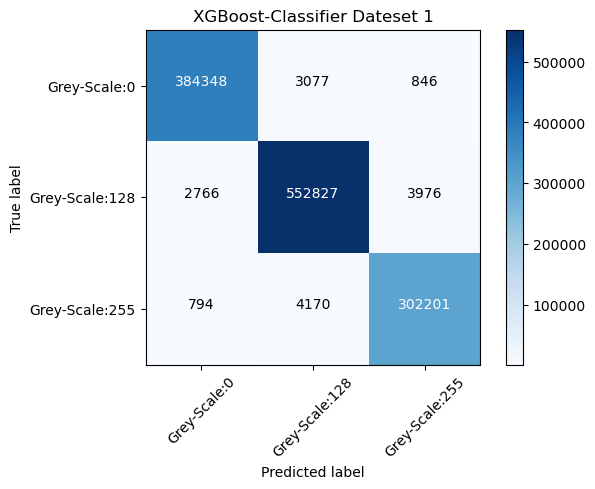

In [ ]:
print_model_metrics(model_NN,loaded_model_XGB,VGG_model,X_val,y_val,501)

<h3>Probabilities if Pixels</h3>

<h3>Plot the results for the first Image</h3>

In [114]:
image_to_plot = 5

image = np.expand_dims(X_test[image_to_plot], axis=0)  # Reshape to (1, 501, 501, 3)
X_test_feature = VGG_model.predict(image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

#Predict XGBoost Image
prediction = loaded_model_XGB.predict(X_test_feature)
prediction_image = prediction.reshape((501, 501))

#Original and labled Images
original_image = np.squeeze(X_test[image_to_plot])
labeled_images = np.squeeze(y_test[image_to_plot])  

#Probabilities
pred_probabilities = loaded_model_XGB.predict_proba(X_test_feature)
class_probabilities_df = pd.DataFrame(pred_probabilities, columns=[f'Class_{i+1}_Prob' for i in range(pred_probabilities.shape[1])])

#Lets get only the once where it is uncertain
filtered_df = class_probabilities_df[(class_probabilities_df < 0.6).all(axis=1)]



1/1 [==============================] - 0s 62ms/step


In [115]:
#Predict NN Image
feature_matrix = X_test_feature.reshape((501 * 501, -1))
# Convert to TensorFlow tensor
feature_tensor = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
# Predict with the model
prediction = model_NN(feature_tensor)  # model is your loaded and compiled neural network model
prediction = tf.nn.softmax(prediction, axis=1)  # As classification dont need softmax we have it here to get probabilities and take the one with the highest argument in the end
predicted_classes = tf.argmax(prediction, axis=1).numpy()
# Reshape the predictions back into image format
prediction_image_NN = predicted_classes.reshape((501, 501))

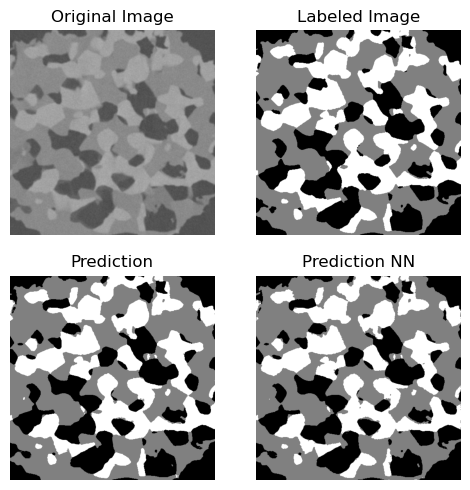

In [128]:
#Plot the different Images


plt.figure(figsize=(5, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(2, 2, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the labeled image
plt.subplot(2, 2, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')
plt.axis('off')

# Plot the prediction image
plt.subplot(2, 2, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Prediction')
plt.axis('off')
# Plot the prediction image
plt.subplot(2, 2, 4)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image_NN, cmap='gray')
plt.title('Prediction NN')
plt.axis('off')
plt.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust wspace and hspace as needed

# Show the plot
plt.show()

<h3>Second Data Set Model Performance</h3>

Unique values in the array: [  0 255]
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 759, 759, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 759, 759, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 759, 759, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 379, 379, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 379, 379, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 379, 379, 128)     147584    
                                                                 
 block2_pool (MaxPoolin

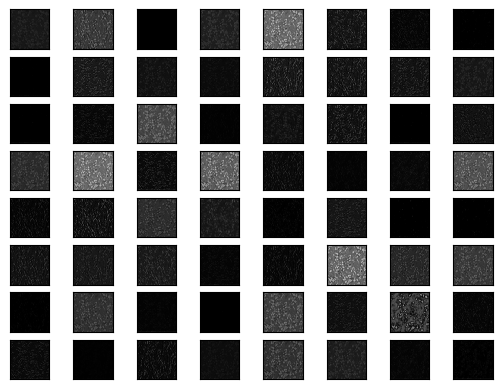

In [130]:
#Same Stuff as last Time, i should put it into a method for data extraktion
X_train, X_test, y_train, y_test = split_data_set_gray_scale('./dataset2/originalpng','./dataset2/mask2', 0.5, [759,759], number_of_data= 10)
#We can set all train that are not 255 to zero

#I have to change all the values of the 
unique_values = np.unique(y_train)
print("Unique values in the array:", unique_values)
features,dataset,VGG_model_2 = get_VGG_model_features(X_train,y_train, [759,759])
#print features
plot_VGG_features(features)


In [131]:
#Check Model accuracy


In [132]:
#Prepare data for training
dataset = dataset.sample(frac=0.99, random_state=1)
#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 255: 1}
# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

In [ ]:
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 
#Save model for future use
path = './Models/model_XGBoost2.sav'
pickle.dump(model, open(path, 'wb'))

In [ ]:
#Train NN for the second model
train_simple_nn(300, X_for_training, Y_for_training, 'NN_Model_VGG_Features_DataSet2_V02', number_output_classes= 2)

In [142]:
#Load Models
#Load Boost Model
path = './Models/model_XGBoost2.sav'
loaded_model_XGB_2 = pickle.load(open(path, 'rb'))
#Load NN Model
number_of_output_classes = 2
model_NN_D2 = SimpleNN(number_of_output_classes)  # Replace with your actual model architecture
sample_input = tf.random.normal([1, 64])  # Replace 'input_shape' with the shape of your model input
model_NN_D2(sample_input)
# Load the weights
model_NN_D2.load_weights('./Models/NN_Model_VGG_Features_DataSet2_V02.h5')

1/1 [==============================] - 0s 107ms/step


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1/1 [==============================] - 0s 113ms/step
Neural Network Model Metrics:
Mean Accuracy: 0.9444244819738892
Mean Precision: 0.9297156037422304
Mean Recall: 0.8982188208443265
Mean F1 Score: 0.9118630179206573
Mean IoU: 0.8430276724145482
Mean Log Loss: 1.388283614633683

Sum/Average Confusion Matrix:
 [[885220  22368]
 [ 41664 202910]]


c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


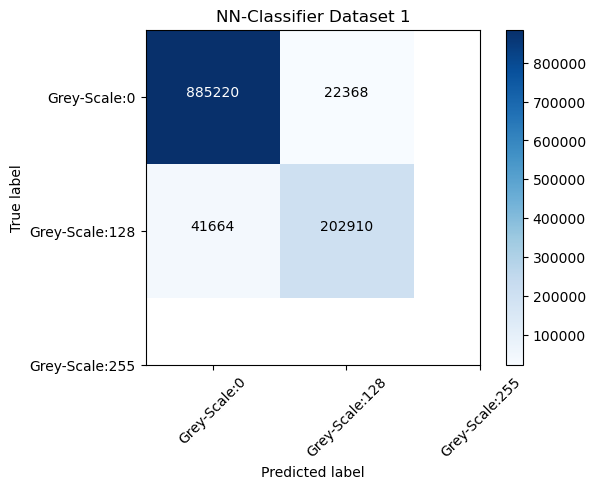


XGBoost Model Metrics:
Mean Accuracy: 0.8919874114924811
Mean Precision: 0.8532316884470867
Mean Recall: 0.9010708898798758
Mean F1 Score: 0.8628518669063151
Mean IoU: 0.7680654546302299
Mean Log Loss: 0.2473422417653487

Sum/Average Confusion Matrix:
 [[800481 107107]
 [ 17341 227233]]


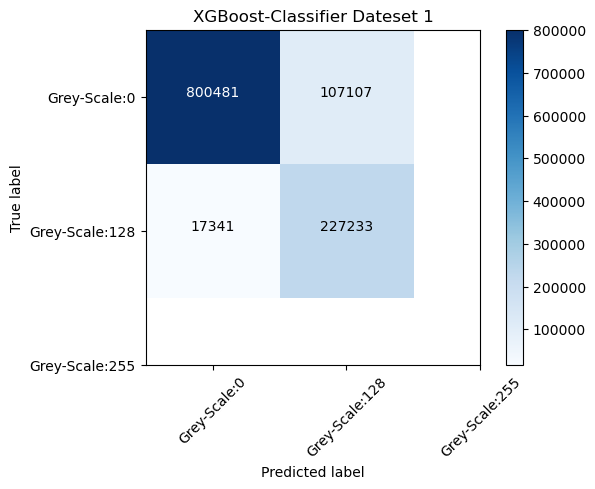

In [143]:
#Check for the errors of the two different models
print_model_metrics(model_NN_D2,loaded_model_XGB_2,VGG_model_2,X_test,y_test,759, true_labels= [0,255])

In [144]:
#Prepare data for plotting

image_to_plot = 1
image = np.expand_dims(X_test[image_to_plot], axis=0)

X_test_feature = VGG_model_2.predict(image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

#Predict XGBoost Image
prediction = loaded_model_XGB_2.predict(X_test_feature)
prediction_image = prediction.reshape((759, 759))

#Predict NN Image
feature_matrix = X_test_feature.reshape((759 * 759, -1))
# Convert to TensorFlow tensor
feature_tensor = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
# Predict with the model
prediction = tf.nn.softmax(model_NN_D2(feature_tensor), axis=1)  # As classification dont need softmax we have it here to get probabilities and take the one with the highest argument in the end
predicted_classes = tf.argmax(prediction, axis=1).numpy()
# Reshape the predictions back into image format
prediction_image_NN = predicted_classes.reshape((759, 759))

1/1 [==============================] - 0s 100ms/step


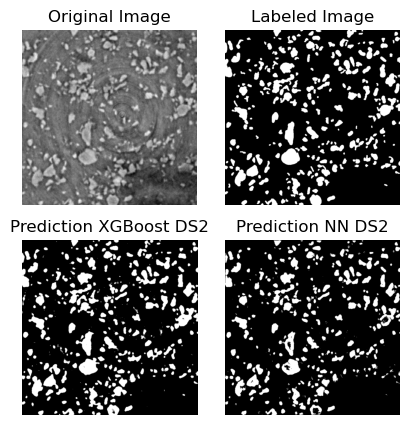

In [145]:
#Original and labled Images
original_image = np.squeeze(X_test[image_to_plot])
labeled_images = np.squeeze(y_test[image_to_plot])  

#Plot the different Images

plt.figure(figsize=(5, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 4, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the labeled image
plt.subplot(1, 4, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')
plt.axis('off')

# Plot the prediction image
plt.subplot(1, 4, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Prediction XGBoost DS2')
plt.axis('off')

# Plot the prediction image
plt.subplot(1, 4, 4)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image_NN, cmap='gray')
plt.title('Prediction NN DS2')
plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust wspace and hspace as needed
# Show the plot
plt.show()

<h3>What happens when we use the classifier trained before</h3>

This really only makes sense when we are looking at the same Problem, I expect it to perform a lot worse as 

In [45]:
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 255: 2}
# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

1/1 [==============================] - 0s 96ms/step


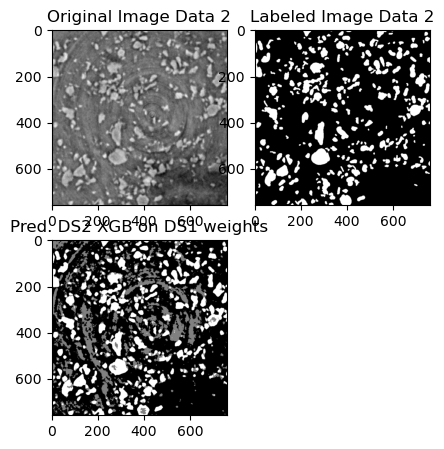

In [137]:
#Load Boost Model
path = './Models/model_XGBoost.sav'
loaded_model_XGB_2 = pickle.load(open(path, 'rb'))

image_to_plot = 1

image = np.expand_dims(X_test[image_to_plot], axis=0)  # Reshape to (1, 501, 501, 3)
X_test_feature = VGG_model_2.predict(image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

#Predict XGBoost Image
prediction = loaded_model_XGB_2.predict(X_test_feature)
prediction_image = prediction.reshape((759, 759))

#Original and labled Images
original_image = np.squeeze(X_test[image_to_plot])
labeled_images = np.squeeze(y_test[image_to_plot])  

#Plot the different Images

plt.figure(figsize=(5, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(2, 2, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image Data 2')
plt.axis('off')


# Plot the labeled image
plt.subplot(2, 2, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image Data 2')
plt.axis('off')

# Plot the prediction image
plt.subplot(2, 2, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Pred. DS2 XGB on DS1 weights')
plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust wspace and hspace as needed
# Show the plot
plt.show()